Install the `nomad` package from GitHub

In [13]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.random as npr
import random
from shapely.geometry import box
from pprint import pprint

import nomad.city_gen as cg
from nomad.city_gen import City, Building, Street
import nomad.traj_gen as tg
from nomad.traj_gen import Agent, Population
import nomad.stop_detection as sd

from nomad.constants import DEFAULT_SPEEDS, FAST_SPEEDS, SLOW_SPEEDS, DEFAULT_STILL_PROBS
from nomad.constants import FAST_STILL_PROBS, SLOW_STILL_PROBS, ALLOWED_BUILDINGS

import os
os.environ['TZ'] = 'UTC'

import pdb

Create City

In [5]:
class RandomCityGenerator:
    def __init__(self, width, height, street_spacing=5, park_ratio=0.1, home_ratio=0.4, work_ratio=0.3, retail_ratio=0.2, seed=42):
        self.seed = seed
        self.width = width
        self.height = height
        self.street_spacing = street_spacing  # Determines regular intervals for streets
        self.park_ratio = park_ratio
        self.home_ratio = home_ratio
        self.work_ratio = work_ratio
        self.retail_ratio = retail_ratio
        self.city = City(dimensions=(width, height))
        self.occupied = np.zeros((self.width, self.height), dtype=bool)  # NumPy array for efficiency
        self.streets = self.generate_streets()
        self.building_sizes = {
            'home': [(2, 2), (1, 2), (2, 1), (1, 1)],  # Mixed sizes
            'work': [(1, 3), (3, 1), (4, 4), (3, 3), (4, 2), (2, 4)],
            'retail': [(1, 3), (3, 1), (4, 4), (3, 3), (2, 4), (4, 2)],
            'park': [(6, 6), (5, 5), (4, 4)]
        }

    def generate_streets(self):
        """Predefine streets in a systematic grid pattern using a NumPy mask."""
        streets = np.zeros((self.width, self.height), dtype=bool)
        streets[::self.street_spacing, :] = True
        streets[:, ::self.street_spacing] = True
        return streets
    
    def get_block_type(self, x, y):
        """Dynamically assigns a block type instead of storing all in memory."""
        npr.seed(self.seed + x * self.width + y)  # Ensure consistency
        return npr.choice(['home', 'work', 'retail', 'park'], 
                          p=[self.home_ratio, self.work_ratio, self.retail_ratio, self.park_ratio])
    
    def fill_block(self, block_x, block_y, block_type):
        """Fills an entire block with buildings."""
        available_space = np.argwhere(~self.occupied[(block_x + 1):(block_x + self.street_spacing), 
                                                     (block_y + 1):(block_y + self.street_spacing)])
        
        if available_space.size == 0:
            return  # No available space in this block

        attempts = 0  # Termination condition to prevent infinite loops
        max_attempts = available_space.shape[0] * 2
        
        while available_space.size > 0 and attempts < max_attempts:
            size = self.building_sizes[block_type][npr.randint(len(self.building_sizes[block_type]))]
            npr.shuffle(available_space)  # Randomize placement within the block
            for x_offset, y_offset in available_space.tolist():
                x, y = block_x + 1 + x_offset, block_y + 1 + y_offset
                if x + size[0] <= block_x + self.street_spacing and y + size[1] <= block_y + self.street_spacing and \
                   np.all(self.occupied[x:(x + size[0]), y:(y + size[1])] == False):
                    door = self.get_adjacent_street((x, y))
                    if door and self.streets[door]:
                        try:
                            self.city.add_building(building_type=block_type, door=door,
                                                   bbox=box(x, y, x + size[0], y + size[1]))
                        except Exception as e:
                            print(f"Skipping building placement at ({x}, {y}) due to error: {e}")
                        self.occupied[x:x + size[0], y:y + size[1]] = True  # Mark occupied
                        occupied_positions = np.array([(x_offset + dx, y_offset + dy) for dx in range(size[0]) for dy in range(size[1])])
                        mask = ~np.any(np.all(available_space[:, None, :] == occupied_positions, axis=2), axis=1)
                        available_space = available_space[mask]
                        break  # Place one building at a time and reattempt filling
            attempts += 1  # Increment attempt counter
    
    def get_adjacent_street(self, location):
        """Finds the closest predefined street to assign as the door, ensuring it’s within bounds."""
        if not location or not isinstance(location, tuple):
            return None
        x, y = location
        possible_streets = np.array([(x + dx, y + dy) for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]])
        
        valid_mask = (possible_streets[:, 0] >= 0) & (possible_streets[:, 0] < self.width) & \
                     (possible_streets[:, 1] >= 0) & (possible_streets[:, 1] < self.height)
        
        valid_streets = possible_streets[valid_mask]
        valid_streets = valid_streets[self.streets[valid_streets[:, 0], valid_streets[:, 1]]]

        return tuple(valid_streets[0].tolist()) if valid_streets.size > 0 else None

    def place_buildings_in_blocks(self):
        """Fills each block completely with buildings using proportional distribution."""
        block_list = [(x, y) for x in range(0, self.width, self.street_spacing)
                      for y in range(0, self.height, self.street_spacing)]
        npr.shuffle(block_list)  # Randomize block processing order

        for block_x, block_y in block_list:
            block_type = self.get_block_type(block_x, block_y)
            self.fill_block(block_x, block_y, block_type)
    
    def generate_city(self):
        """Generates a systematically structured city where blocks are fully occupied with buildings."""
        self.place_buildings_in_blocks()
        self.city.get_street_graph()
        return self.city if len(self.city.buildings) > 0 else None

In [6]:
city_generator = RandomCityGenerator(width=101, 
                                     height=101, 
                                     street_spacing=5, 
                                     park_ratio=0.05, 
                                     home_ratio=0.4, 
                                     work_ratio=0.3, 
                                     retail_ratio=0.25, 
                                     seed=100)
clustered_city = city_generator.generate_city()

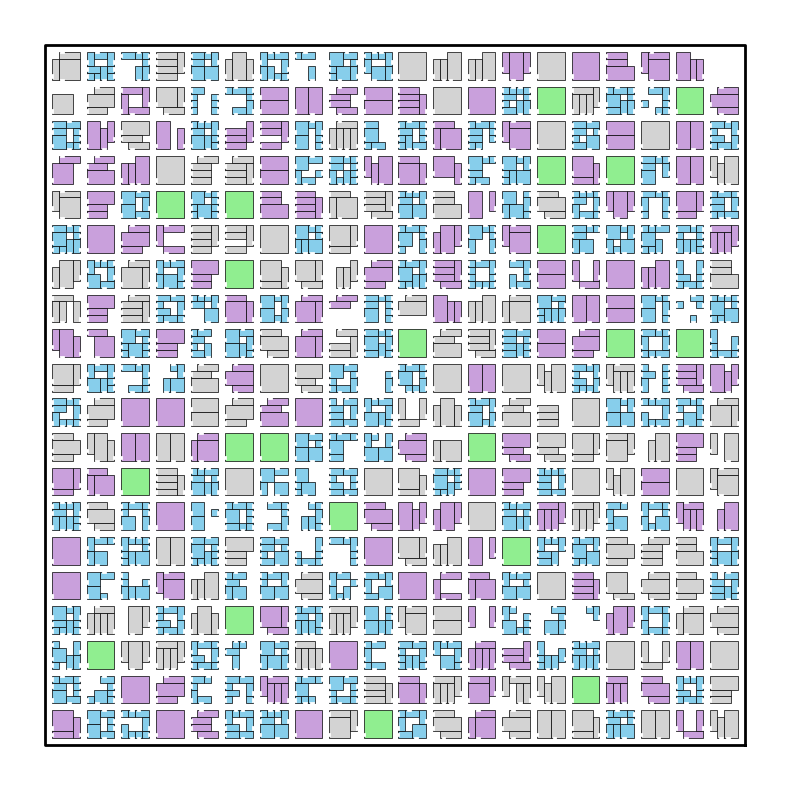

<Figure size 640x480 with 0 Axes>

In [7]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 10))
plt.box(on=False)

clustered_city.plot_city(ax, doors=True, address=False)

# remove axis labels and ticks
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.show()
plt.savefig("random-city.png")

In [ ]:
population = Population(clustered_city)
population.generate_agents(N=1, seed=100)

for i, agent_id in enumerate(population.roster):
    agent = population.roster[agent_id]
    agent.generate_trajectory(end_time=pd.Timestamp(2025, 1, 8, hour=0, minute=0),
                              seed=100+i)
    agent.sample_trajectory(
        beta_start=300,
        beta_durations=60,
        beta_ping=10,
        seed=100+i)
    sampled_traj = agent.sparse_traj

/Users/andresmondragon/nomad/nomad/traj_gen.py:569: UserWarning: The end_time input is timezone-naive. Assuming it is in UTC.
  warnings.warn(


In [16]:
Zach = population.roster['nifty_saha']

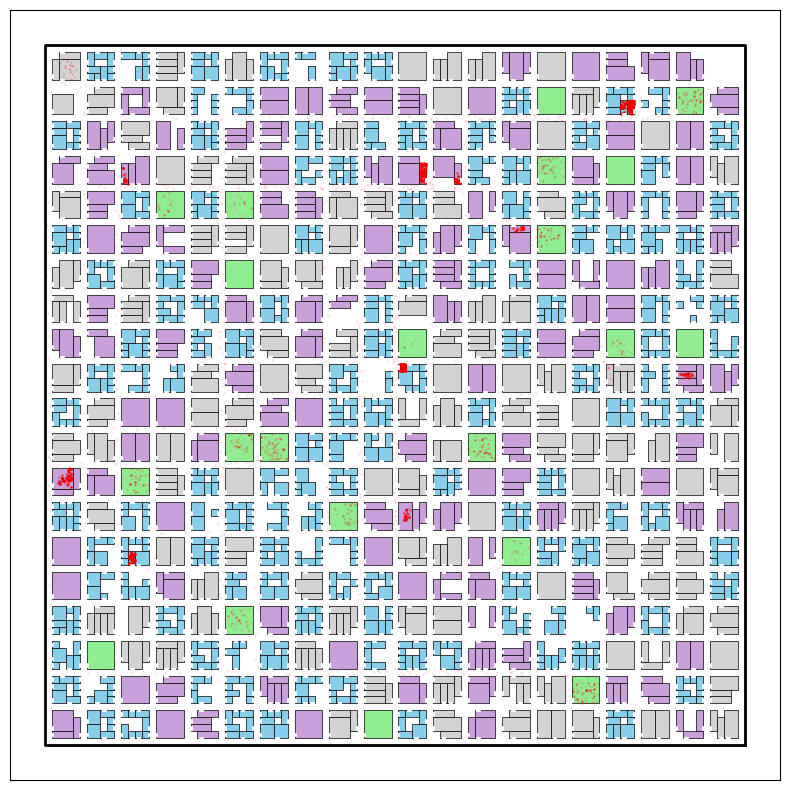

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
clustered_city.plot_city(ax, doors=True, address=False, zorder=1)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.scatter(x=Zach.trajectory.x, 
           y=Zach.trajectory.y, 
           s=0.5, color='red', alpha=0.1)

plt.savefig("random-city-one-user.png")